In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# **Data PreProcessing**

In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [62]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

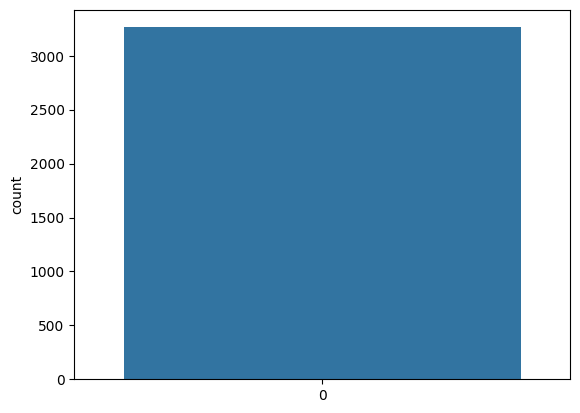

In [63]:
X_train = []
Y_train = []
image_size = 224  
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for label in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Training', label)
    for img_name in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, img_name))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)


for label in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Testing', label)
    for img_name in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, img_name))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)


X_train = np.array(X_train)
Y_train = np.array(Y_train)


X_train = X_train / 255.0

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)

sns.countplot(Y_train.argmax(axis=1))
plt.show()


In [64]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(3264, 224, 224, 3)

In [65]:

from sklearn.utils.class_weight import compute_class_weight
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train.argmax(axis=1)),
    y=Y_train.argmax(axis=1)
)
class_weights = dict(enumerate(class_weights))


# **Model Training(Resnet50)**

In [66]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [67]:
# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,  # Experiment with different batch sizes
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.4837 - loss: 1.6813 - val_accuracy: 0.4824 - val_loss: 2.0099 - learning_rate: 1.0000e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6110 - loss: 1.2096 - val_accuracy: 0.3752 - val_loss: 2.0867 - learning_rate: 1.0000e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.6837 - loss: 0.9613 - val_accuracy: 0.5345 - val_loss: 1.3288 - learning_rate: 1.0000e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.6817 - loss: 0.9327 - val_accuracy: 0.6049 - val_loss: 1.1391 - learning_rate: 1.0000e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7144 - loss: 0.8785 - val_accuracy: 0.6570 - val_loss: 0.9735 - learning_rate: 1.0000e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7075 - loss: 0.8069 - val_accuracy: 0.6217 - val_loss: 1.0595 - learning_rate: 1.0000e-04
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.755

# **Model Evaluation**

In [68]:

val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f'Validation Accuracy: {val_acc:.2f}')

Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_val, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
target_names = lb.classes_
print(classification_report(y_true, y_pred, target_names=target_names))


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8182 - loss: 0.5758
Validation Accuracy: 0.83
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step
Confusion Matrix
[[142  35   9   1]
 [ 25 143   8   8]
 [  2   6  87   1]
 [  6   9   2 169]]
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.76      0.78       187
meningioma_tumor       0.74      0.78      0.76       184
        no_tumor       0.82      0.91      0.86        96
 pituitary_tumor       0.94      0.91      0.93       186

        accuracy                           0.83       653
       macro avg       0.83      0.84      0.83       653
    weighted avg       0.83      0.83      0.83       653



# **Output Visualisation**

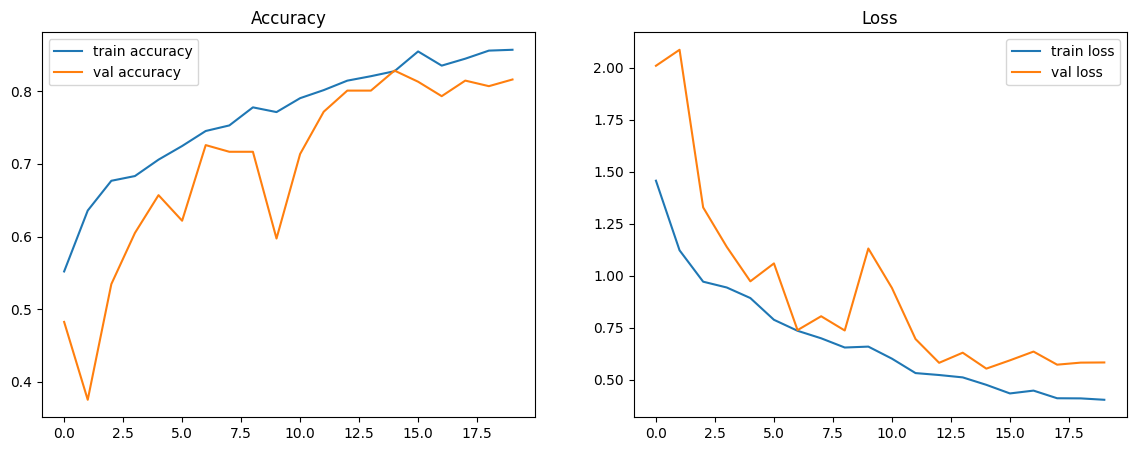

In [69]:

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()


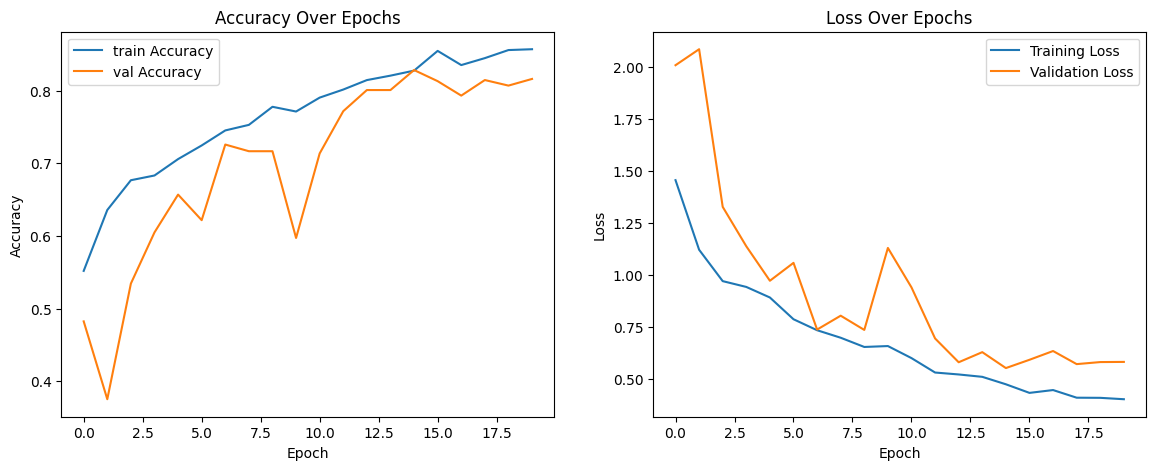

In [70]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train Accuracy')
plt.plot(history.history['val_accuracy'], label='val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()


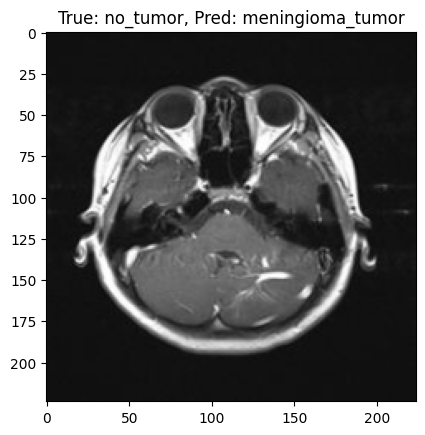

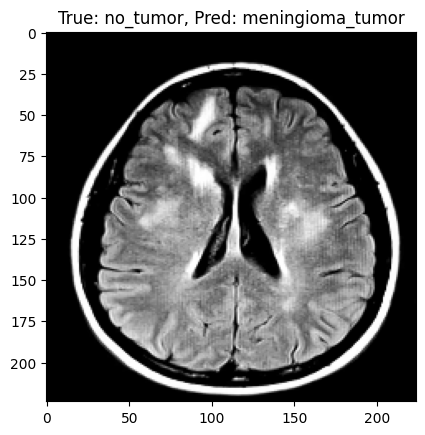

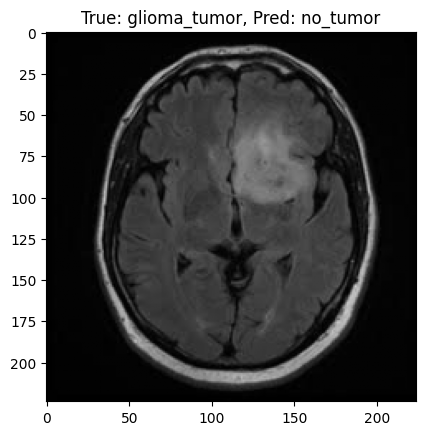

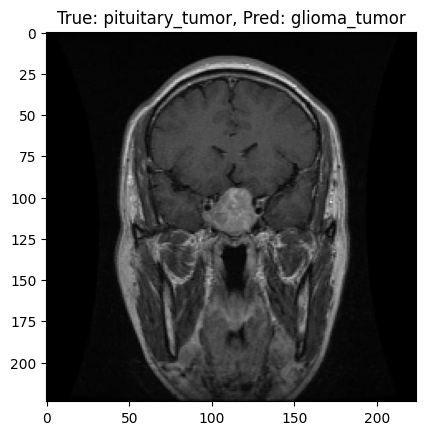

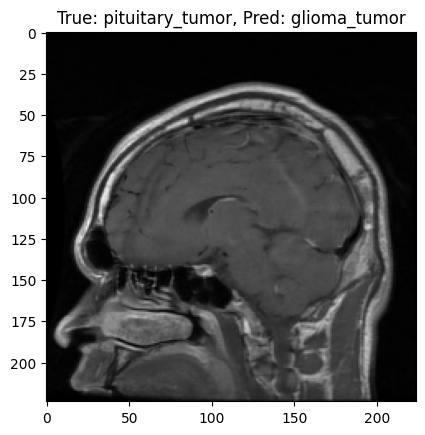

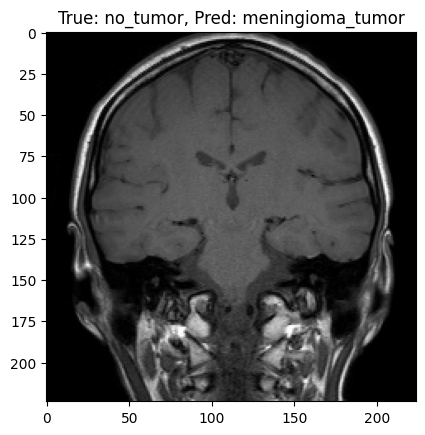

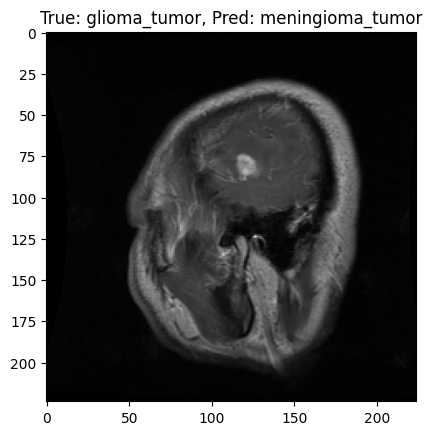

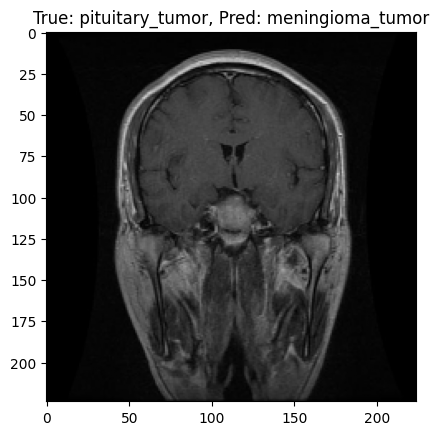

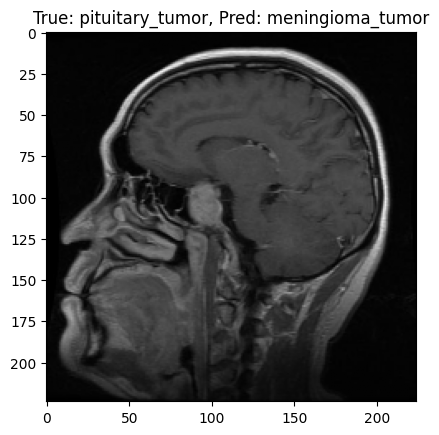

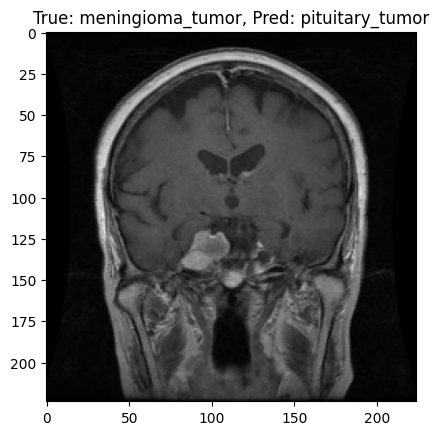

In [71]:

incorrect_indices = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i]]
for i in incorrect_indices[:10]: 
    plt.imshow(X_val[i])
    plt.title(f"True: {target_names[y_true[i]]}, Pred: {target_names[y_pred[i]]}")
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


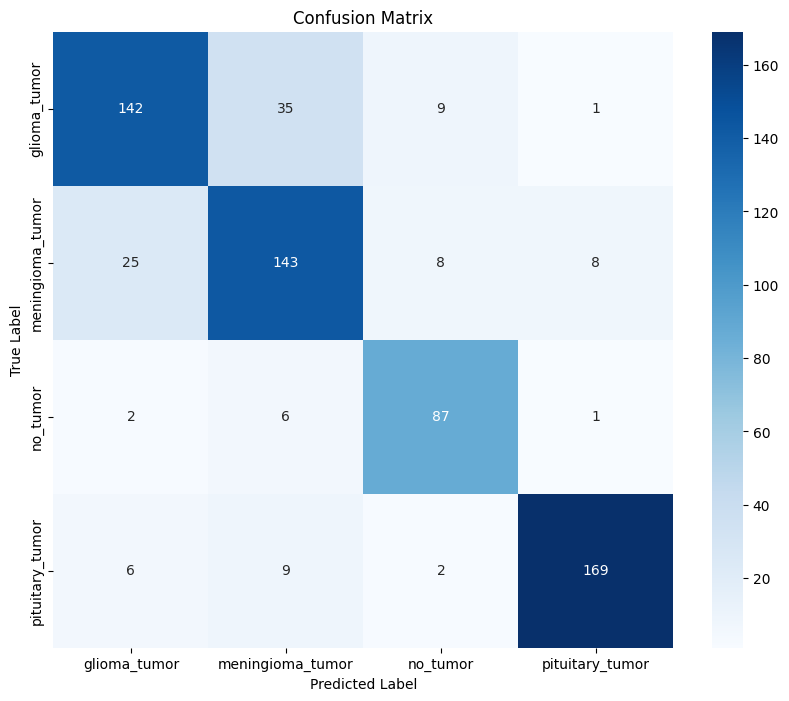

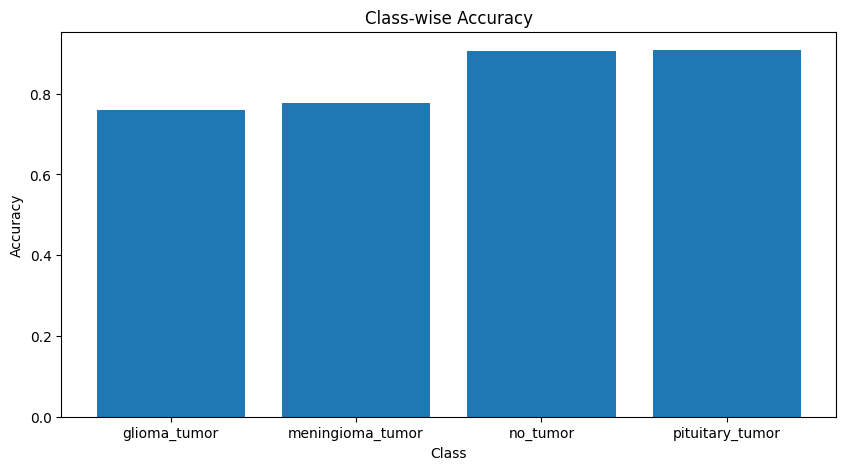

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_accuracies = np.array([np.mean(Y_pred_classes[Y_true == i] == i) for i in range(len(labels))])

plt.figure(figsize=(10, 5))
plt.bar(labels, class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8228 - loss: 0.4616


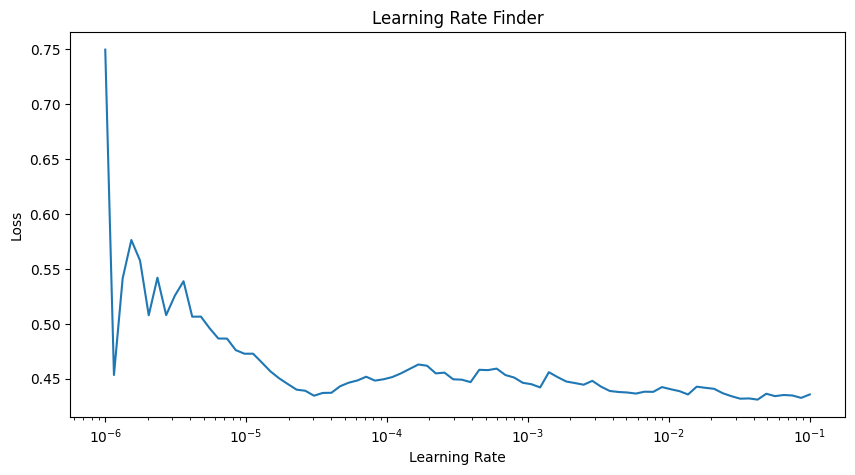

In [73]:

from tensorflow.keras.callbacks import Callback

class LearningRateFinder(Callback):
    def __init__(self, start_lr, end_lr, num_batches):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_batches = num_batches
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)
        self.lrs = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.start_lr * (self.lr_mult ** batch)
        self.lrs.append(lr)
        self.losses.append(logs['loss'])


lr_finder = LearningRateFinder(start_lr=1e-6, end_lr=1e-1, num_batches=len(X_train) // 32)
history = model.fit(X_train, Y_train, epochs=1, batch_size=32, callbacks=[lr_finder])

plt.figure(figsize=(10, 5))
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()


In [58]:
print(history.history.keys())


dict_keys(['accuracy', 'loss'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


W0000 00:00:1722681051.203978     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


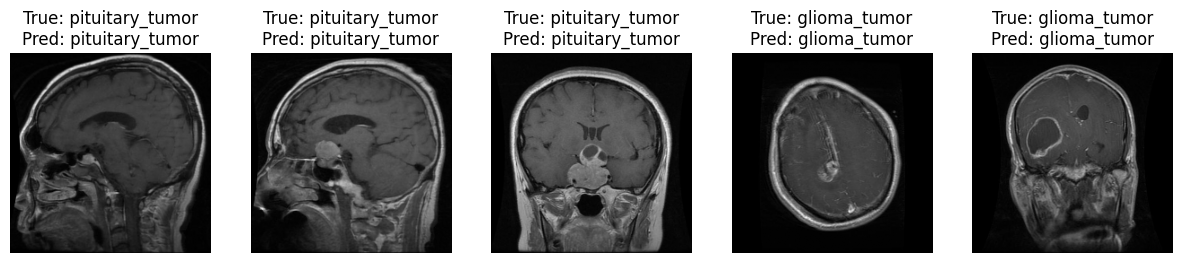

In [74]:

num_samples = 5
indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[indices]
sample_labels = Y_val[indices]
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {labels[true_labels[i]]}\nPred: {labels[predicted_labels[i]]}")
    plt.axis('off')

plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


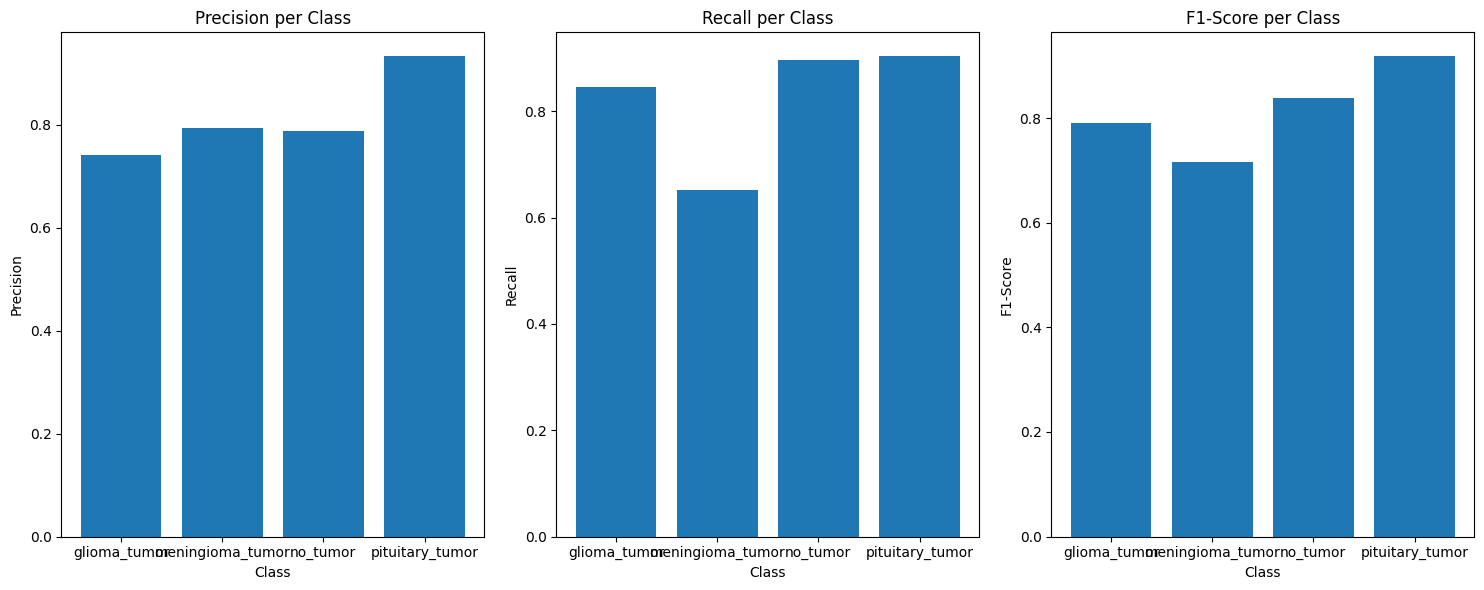

In [75]:
from sklearn.metrics import classification_report

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

report = classification_report(Y_true, Y_pred_classes, target_names=labels, output_dict=True)

precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.bar(x, precision, tick_label=labels)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')

plt.subplot(1, 3, 2)
plt.bar(x, recall, tick_label=labels)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per Class')

plt.subplot(1, 3, 3)
plt.bar(x, f1_score, tick_label=labels)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score per Class')

plt.tight_layout()
plt.show()


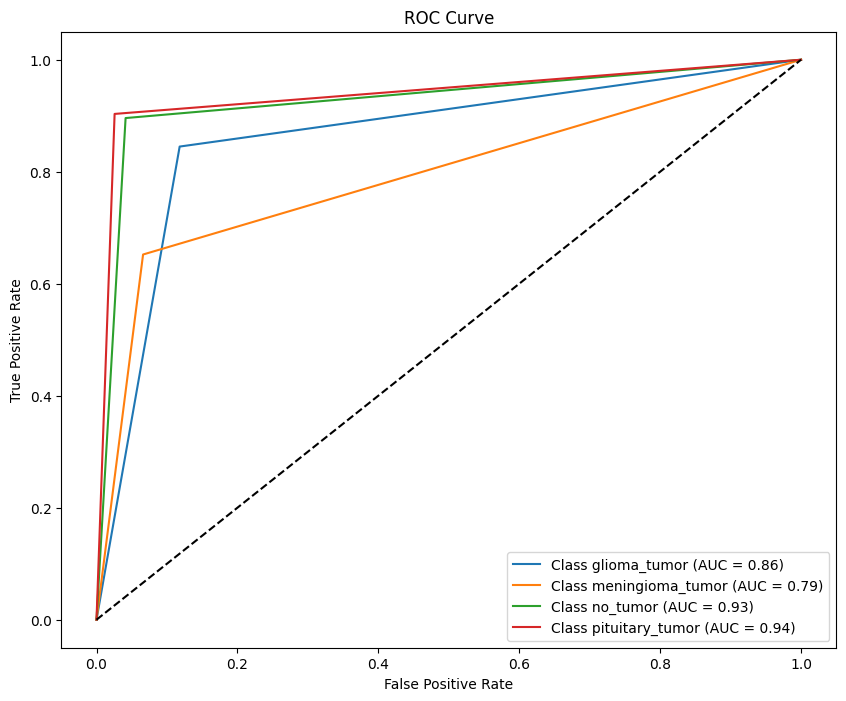

In [76]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

Y_val_bin = label_binarize(Y_true, classes=np.arange(len(labels)))
Y_pred_bin = label_binarize(Y_pred_classes, classes=np.arange(len(labels)))

plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(Y_val_bin[:, i], Y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


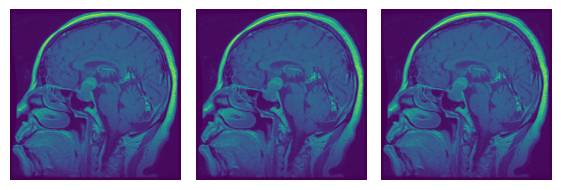

In [77]:
from tensorflow.keras.models import Model


layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

sample_image = X_val[0:1]  
activations = activation_model.predict(sample_image)

first_layer_activation = activations[0][0]
plt.figure(figsize=(15, 15))
for i in range(first_layer_activation.shape[-1]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(first_layer_activation[:, :, i], cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


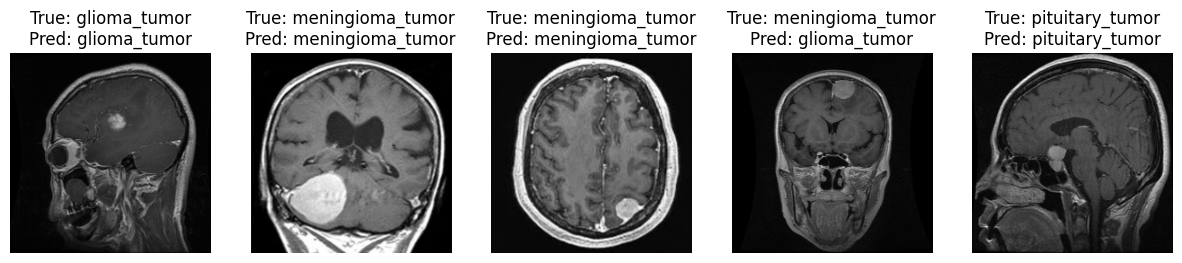

In [78]:

num_samples = 5
indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[indices]
sample_labels = Y_val[indices]
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {labels[true_labels[i]]}\nPred: {labels[predicted_labels[i]]}")
    plt.axis('off')

plt.show()


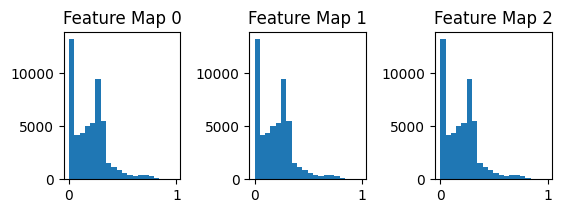

In [81]:

first_layer_activation = activations[0][0]
plt.figure(figsize=(15, 15))
for i in range(first_layer_activation.shape[-1]):
    plt.subplot(8, 8, i + 1)
    plt.hist(first_layer_activation[:, :, i].flatten(), bins=20)
    plt.title(f'Feature Map {i}')
plt.tight_layout()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


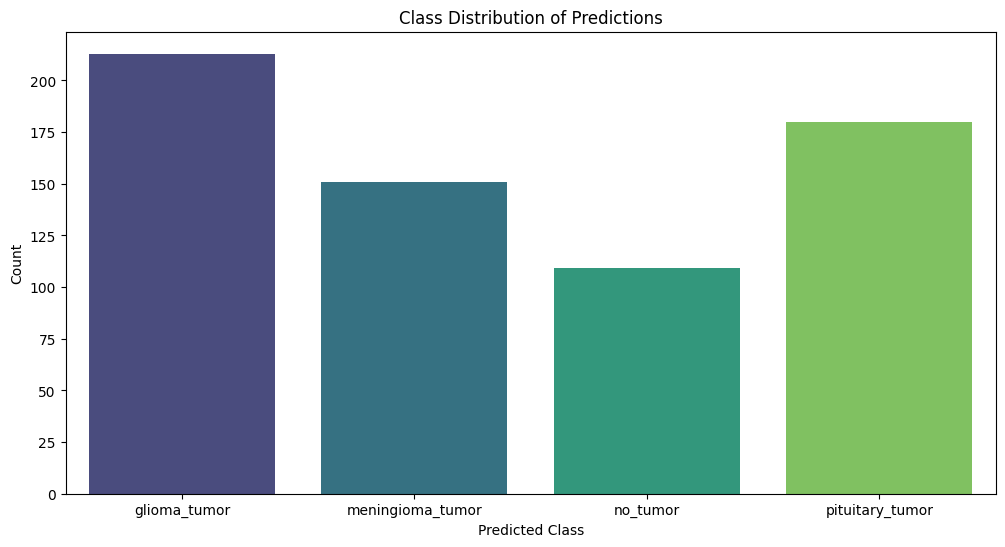

In [83]:
import seaborn as sns


Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(x=Y_pred_classes, palette='viridis')
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Class Distribution of Predictions')
plt.show()
